In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [102]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "apenas suporta int e float"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other): #fallback da multiplicacao de other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # derivada de exp é ela mesma

        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    


In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

In [7]:
x = Value(2.0)
y = Value(4.0)
y - x

Value(data=2.0)

In [10]:
d._op

'+'

In [11]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    nodes, edges = trace(root)
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

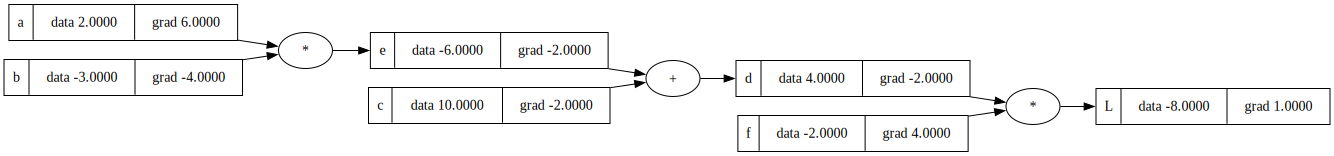

In [52]:
draw_dot(L)

In [ ]:
L = d * f

In [40]:
f.grad = 4.0
d.grad = -2.0

In [54]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [47]:
c.grad = -2.0
e.grad = -2.0

In [51]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2

In [150]:
print(L.data)
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

e = a*b
d = e + c
L = d * f
print(L.data)


-79.66799999999981
-82.7970559999998


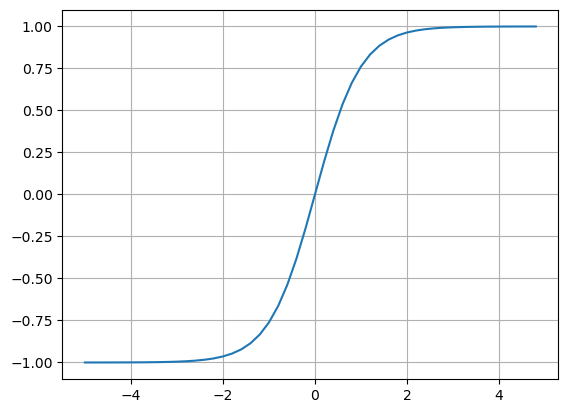

In [151]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [8]:
# entradas do neuronio x1 e x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# pesos w1 e w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias do neuronio
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

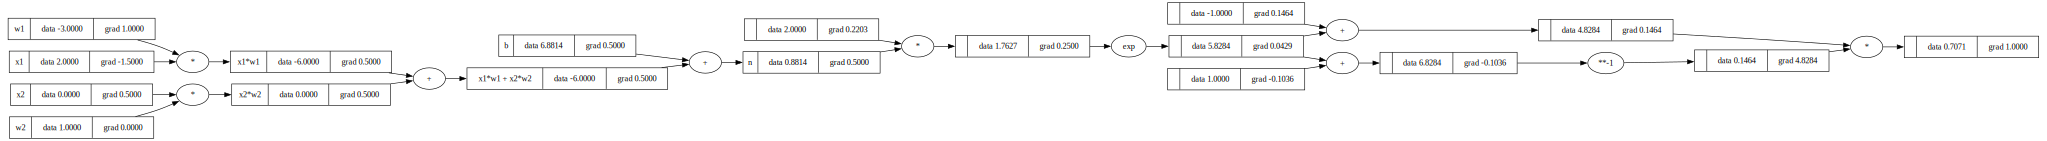

In [22]:
draw_dot(o)

In [20]:
# entradas do neuronio x1 e x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# pesos w1 e w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias do neuronio
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

# o = n.tanh(); o.label = 'o'

In [21]:
o.backward()

In [191]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

#o._backward()

#n._backward()

#b._backward()

#x1w1x2w2._backward()

#x1w1._backward()
#x2w2._backward()

In [187]:
# ordenacao topologica para organizar os nós de forma com que eles só apontem em uma direção
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [166]:
# backprop na mão
o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - o ** 2 = 0.5

n.grad = 0.5

# gradriente de uma soma só propaga o gradiente da operacao seguinte
x1w1x2w2.grad = 0.5
b.grad = 0.5

# gradiente da soma
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


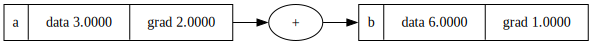

In [ ]:
# bug (acontece quando uma variavel é usada mais de uma vez, acontece uma sobrescrita no gradiente)
# para corrigir trocamos a atribuicao de gradiente por uma acumulacao (+=)
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [203]:
h = 1
eh = math.exp(h)
eh_minus1 = eh - 1
limit = eh_minus1 / h

print(eh)
print(eh_minus1)
print(limit)


2.718281828459045
1.718281828459045
1.718281828459045


In [204]:
h = 0.1
eh = math.exp(h)
eh_minus1 = eh - 1
limit = eh_minus1 / h

print(eh)
print(eh_minus1)
print(limit)


1.1051709180756477
0.10517091807564771
1.0517091807564771


In [205]:
h = 0.01
eh = math.exp(h)
eh_minus1 = eh - 1
limit = eh_minus1 / h

print(eh)
print(eh_minus1)
print(limit)

1.010050167084168
0.010050167084167949
1.005016708416795


In [206]:
h = 0.001
eh = math.exp(h)
eh_minus1 = eh - 1
limit = eh_minus1 / h

print(eh)
print(eh_minus1)
print(limit)

1.0010005001667084
0.0010005001667083846
1.0005001667083846


In [23]:
# agora com pytorch
import torch

In [26]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [109]:
# neural nets
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # return [p for neuron in self.neurons for p in neuron.parameters()]
        
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [171]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.681654376163238)

In [172]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]
ys = [1.0, -1.0, -1.0, 1.0]


In [181]:
for k in range(200):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0 # resetar o gradiente

    # backprop
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    
    print(k, loss.data)


0 0.000497246506380004
1 0.0004960564433347738
2 0.000494871949220776
3 0.0004936929853504239
4 0.0004925195133921056
5 0.0004913514953660877
6 0.0004901888936405038
7 0.0004890316709274034
8 0.0004878797902788186
9 0.00048673321508292867
10 0.0004855919090602573
11 0.00048445583625990725
12 0.00048332496105586584
13 0.0004821992481433428
14 0.00048107866253519854
15 0.00047996316955836786
16 0.00047885273485034625
17 0.0004777473243557399
18 0.00047664690432285505
19 0.00047555144130032154
20 0.0004744609021337777
21 0.0004733752539625884
22 0.0004722944642166064
23 0.00047121850061296463
24 0.00047014733115295984
25 0.0004690809241189029
26 0.0004680192480710742
27 0.00046696227184468665
28 0.0004659099645468885
29 0.00046486229555381446
30 0.0004638192345076855
31 0.0004627807513139275
32 0.0004617468161383107
33 0.00046071739940418467
34 0.0004596924717896851
35 0.00045867200422500926
36 0.00045765596788972557
37 0.000456644334210114
38 0.0004556370748565454
39 0.000454634161740857

In [182]:
ypred

[Value(data=0.9921776612612885),
 Value(data=-0.990390751703646),
 Value(data=-0.9913014547838798),
 Value(data=0.989680894916688)]

In [144]:
loss.backward()

In [116]:
n.layers[0].neurons[0].w[0].grad

1.1104648602153402

In [119]:
n.layers[0].neurons[0].w[0].data

-0.5190610442533626

In [145]:
for p in n.parameters():
    p.data += -0.1 * p.grad

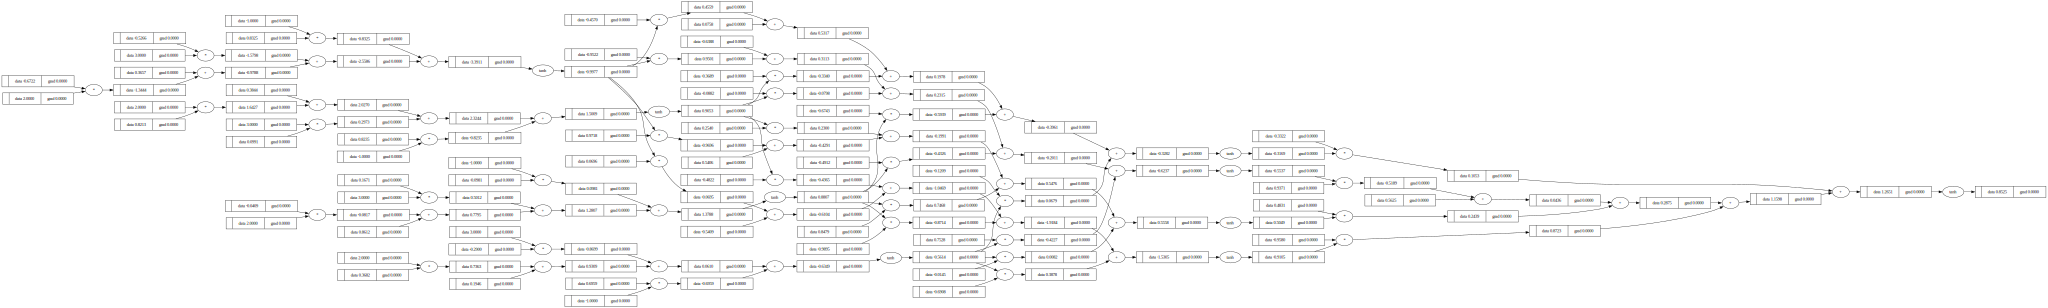

In [93]:
draw_dot(n(x))

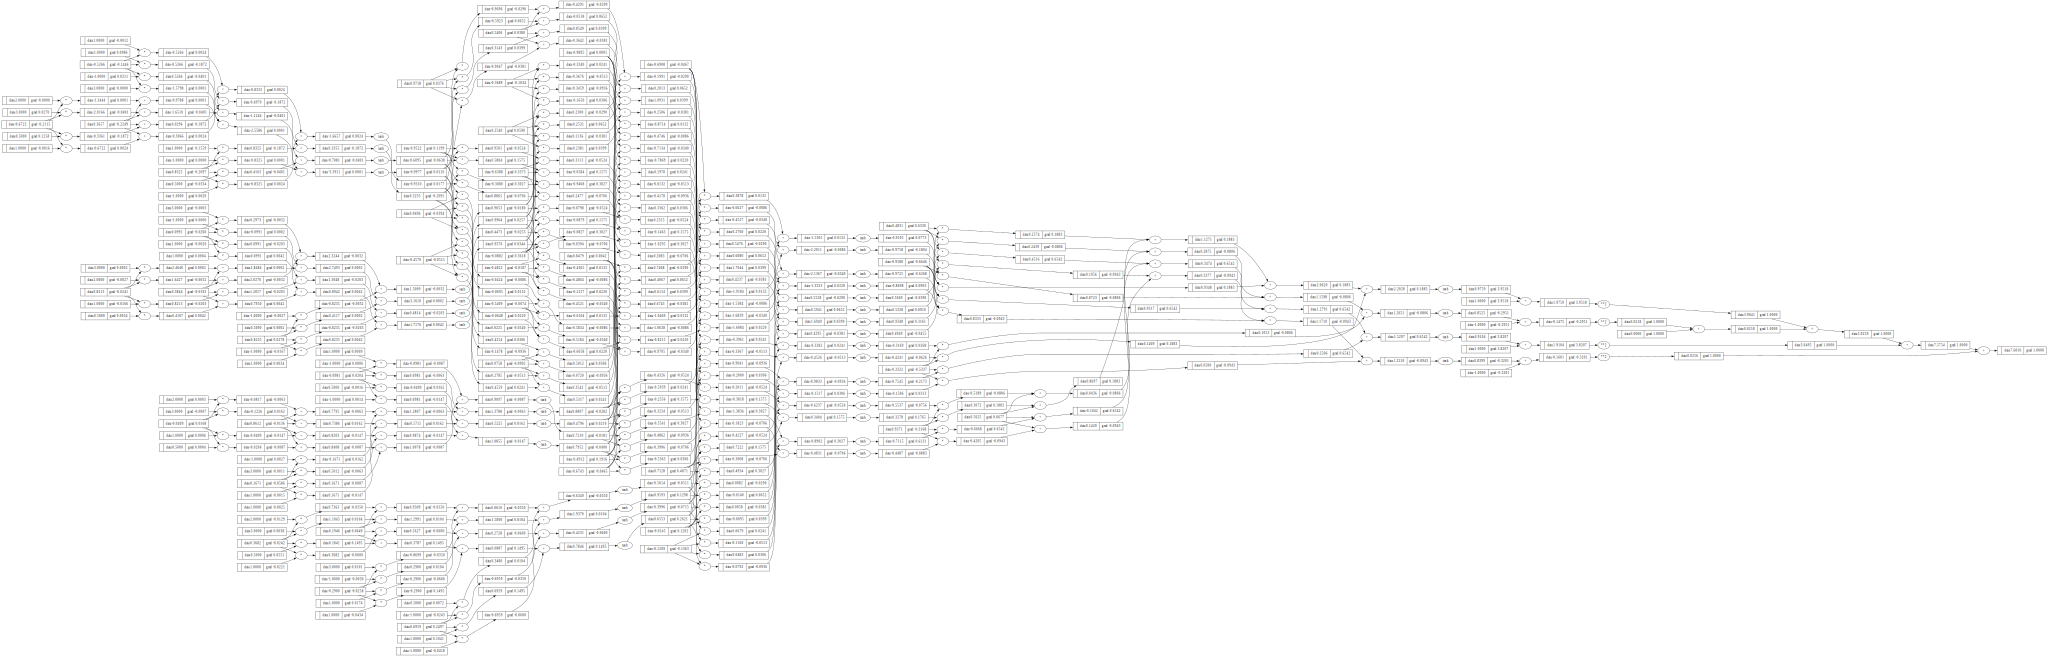

In [108]:
draw_dot(loss)